In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adamax # type: ignore
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization # type: ignore
from tensorflow.keras.applications import ResNet50, EfficientNetB0, DenseNet121 # type: ignore
from tensorflow.keras import regularizers # type: ignore
from tensorflow.keras.utils import plot_model  # type: ignore
from IPython.display import Image, display
import time
import os

# General settings
img_height = 64
img_width = 64
batch_size = 250


In [2]:

print(tf.__version__)


2.9.1


# Importing Data

In [3]:
# Split training data
train_ds = tf.keras.utils.image_dataset_from_directory(
 "train",
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  
  )
# Split validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    "train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)


# Load the validation data
test_ds = tf.keras.utils.image_dataset_from_directory(
  "test",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = train_ds.class_names
print(class_names)




Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# for stopping epoch when the model is overfitting and restoring the best weights
call_back = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True) 

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_data = val_ds.prefetch(buffer_size=AUTOTUNE)

##### Autotune for better pipeline efficiency

In [6]:
# Function to plot model architecture
def plot_model_architecture(model, filename):
    plot_model(model, show_shapes=True, to_file=filename)
    display(Image(filename))

In [7]:
def plot_graph_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
def plot_graph_acc(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Training vs Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
        

# ResNet50

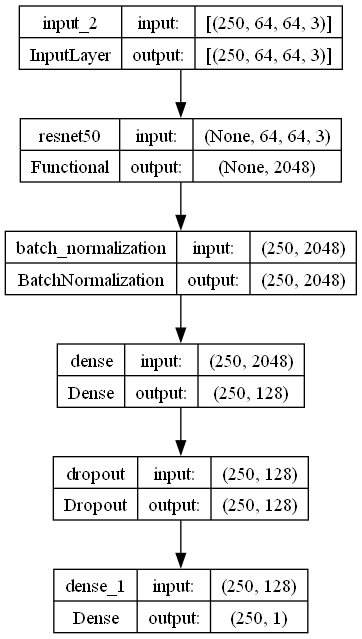

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(250, 64, 64, 3)]        0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (BatchN  (250, 2048)              8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (250, 128)                262272    
                                                                 
 dropout (Dropout)           (250, 128)                0         
                                                                 
 dense_1 (Dense)             (250, 1)                  129       
                                                             

In [8]:
# Load and create Resnet model

resnet_base = ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(img_height, img_width, 3),
                       pooling='max')
resnet_base.trainable = True
inputs = tf.keras.Input((img_height,img_width,3),batch_size)
x = resnet_base(inputs)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer = regularizers.l2(0.01))(x)
x = Dropout(rate=0.4, seed=123)(x)
outputs = Dense(1, activation='sigmoid')(x)
Resnet50 = tf.keras.Model(inputs, outputs)
Resnet50.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
plot_model_architecture(Resnet50, "Resnet64.png")
Resnet50.summary()
# Dictionary to store training and evaluation times
stats = {}

In [9]:
# Measure training time
start_time = time.time()
Resnet_history = Resnet50.fit(
    train_data,
    validation_data=validation_data,
    epochs=100,
    callbacks=[call_back,reduce_lr],
    verbose=1
)
training_time = time.time() - start_time
print(f"Resnet50 Training Time: {training_time:.2f} seconds")

Epoch 1/100
320/320 [==============================] - 79s 219ms/step - loss: 0.9804 - accuracy: 0.9492 - precision: 0.9476 - recall: 0.9509 - val_loss: 0.3409 - val_accuracy: 0.9660 - val_precision: 0.9578 - val_recall: 0.9748 - lr: 0.0010
Epoch 2/100
320/320 [==============================] - 60s 185ms/step - loss: 0.1582 - accuracy: 0.9840 - precision: 0.9845 - recall: 0.9835 - val_loss: 0.1457 - val_accuracy: 0.9649 - val_precision: 0.9550 - val_recall: 0.9757 - lr: 0.0010
Epoch 3/100
320/320 [==============================] - 63s 195ms/step - loss: 0.0522 - accuracy: 0.9889 - precision: 0.9893 - recall: 0.9885 - val_loss: 0.2159 - val_accuracy: 0.9364 - val_precision: 0.9941 - val_recall: 0.8779 - lr: 0.0010
Epoch 4/100
320/320 [==============================] - 65s 203ms/step - loss: 0.0390 - accuracy: 0.9886 - precision: 0.9885 - recall: 0.9887 - val_loss: 0.1153 - val_accuracy: 0.9681 - val_precision: 0.9786 - val_recall: 0.9570 - lr: 0.0010
Epoch 5/100
320/320 [===============

In [10]:

# Measure evaluation time
start_time = time.time()
test_loss, test_accuracy, test_precision, test_recall = Resnet50.evaluate(test_ds)
evaluation_time = time.time() - start_time

print(f"Resnet50 Evaluation Time: {evaluation_time:.2f} seconds")

80/80 [==============================] - 17s 194ms/step - loss: 0.0911 - accuracy: 0.9811 - precision: 0.9825 - recall: 0.9797
Resnet50 Evaluation Time: 17.33 seconds


In [11]:

# Save model and print size
Resnet50.save("Resnet5064.h5")
Resnet50_model_size = os.path.getsize("Resnet5064.h5")
print(f"Resnet Model Size: {Resnet50_model_size / (1024 * 1024):.2f} MB")

# Store the metrics and times in the dictionary
stats[Resnet50] = {
    "training_time": training_time,
    "evaluation_time": evaluation_time,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "model_size": Resnet50_model_size / (1024 * 1024),
    "history": Resnet_history
}


Resnet Model Size: 273.41 MB


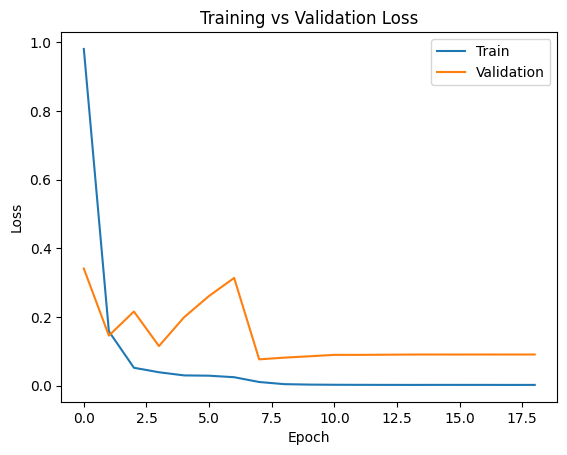

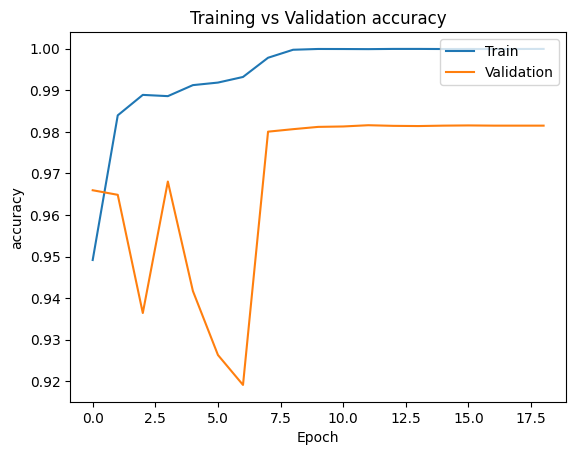

In [12]:
plot_graph_loss(Resnet_history)
plot_graph_acc(Resnet_history)


# Efficient Net

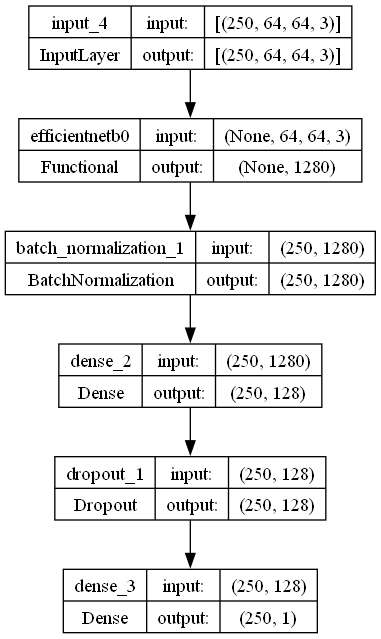

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(250, 64, 64, 3)]        0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization_1 (Batc  (250, 1280)              5120      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (250, 128)                163968    
                                                                 
 dropout_1 (Dropout)         (250, 128)                0         
                                                                 
 dense_3 (Dense)             (250, 1)                  129       
                                                           

In [13]:
# Load and create EfficientNet model

EfficientNet_base = EfficientNetB0(weights='imagenet',
                       include_top=False,
                       input_shape=(img_height, img_width, 3),
                       pooling='max')
EfficientNet_base.trainable = True
inputs = tf.keras.Input((img_height,img_width,3),batch_size)
x = EfficientNet_base(inputs)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer = regularizers.l2(0.01))(x)
x = Dropout(rate=0.4, seed=123)(x)
outputs = Dense(1, activation='sigmoid')(x)
EfficientNet = tf.keras.Model(inputs, outputs)
EfficientNet.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
plot_model_architecture(EfficientNet, "EfficientNet64.png")
EfficientNet.summary()

In [14]:

# Measure training time
start_time = time.time()
EfficientNet_history = EfficientNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[call_back,reduce_lr],
    verbose=1
)
training_time = time.time() - start_time
print(f"EfficientNet Training Time: {training_time:.2f} seconds")


Epoch 1/100
320/320 [==============================] - 67s 182ms/step - loss: 0.9758 - accuracy: 0.9334 - precision_1: 0.9332 - recall_1: 0.9336 - val_loss: 0.3495 - val_accuracy: 0.9525 - val_precision_1: 0.9262 - val_recall_1: 0.9833 - lr: 0.0010
Epoch 2/100
320/320 [==============================] - 59s 183ms/step - loss: 0.1727 - accuracy: 0.9742 - precision_1: 0.9749 - recall_1: 0.9735 - val_loss: 0.1179 - val_accuracy: 0.9714 - val_precision_1: 0.9777 - val_recall_1: 0.9647 - lr: 0.0010
Epoch 3/100
320/320 [==============================] - 60s 186ms/step - loss: 0.0649 - accuracy: 0.9844 - precision_1: 0.9849 - recall_1: 0.9840 - val_loss: 0.0959 - val_accuracy: 0.9728 - val_precision_1: 0.9746 - val_recall_1: 0.9709 - lr: 0.0010
Epoch 4/100
320/320 [==============================] - 61s 190ms/step - loss: 0.0398 - accuracy: 0.9896 - precision_1: 0.9899 - recall_1: 0.9894 - val_loss: 0.0880 - val_accuracy: 0.9750 - val_precision_1: 0.9756 - val_recall_1: 0.9745 - lr: 0.0010
Epoc

In [15]:

# Measure evaluation time
start_time = time.time()
test_loss, test_accuracy, test_precision, test_recall = EfficientNet.evaluate(test_ds)
evaluation_time = time.time() - start_time
print(f"EfficientNet Evaluation Time: {evaluation_time:.2f} seconds")

print(f"EfficientNet - Test Loss: { test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")


80/80 [==============================] - 7s 83ms/step - loss: 0.0795 - accuracy: 0.9819 - precision_1: 0.9805 - recall_1: 0.9834
EfficientNet Evaluation Time: 7.06 seconds
EfficientNet - Test Loss: 0.0795, Test Accuracy: 0.9819, Precision: 0.9805, Recall: 0.9834


In [16]:
# Save model and print size
EfficientNet.save("EfficientNet64.h5")
EfficientNet_model_size = os.path.getsize("EfficientNet64.h5")
print(f"EfficientNet Model Size: {EfficientNet_model_size / (1024 * 1024):.2f} MB")


EfficientNet Model Size: 48.84 MB


In [17]:
# Store the metrics and times in the dictionary
stats[EfficientNet] = {
    "training_time": training_time,
    "evaluation_time": evaluation_time,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "model_size":EfficientNet_model_size,
    "history": EfficientNet_history
}

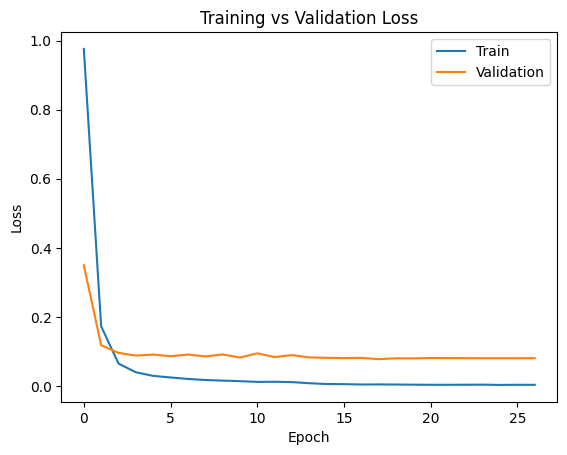

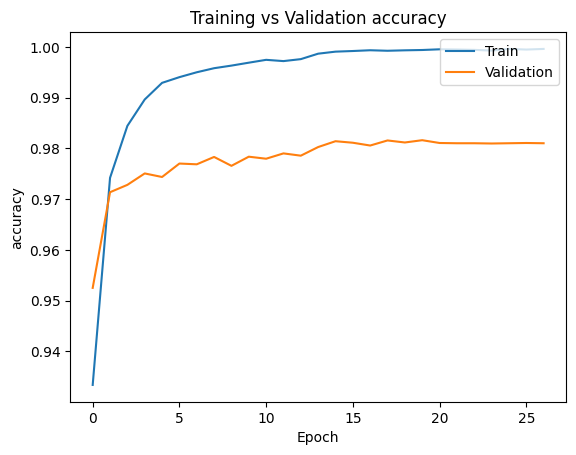

In [18]:
plot_graph_loss(EfficientNet_history)
plot_graph_acc(EfficientNet_history)



# DenseNet

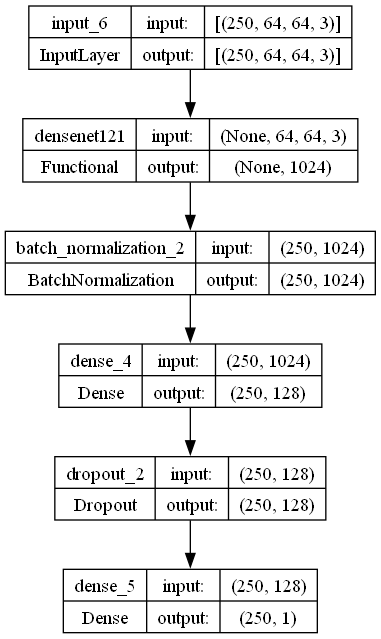

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(250, 64, 64, 3)]        0         
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_2 (Batc  (250, 1024)              4096      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (250, 128)                131200    
                                                                 
 dropout_2 (Dropout)         (250, 128)                0         
                                                                 
 dense_5 (Dense)             (250, 1)                  129       
                                                           

In [19]:
# Load and create EfficientNet model

DenseNet_base = DenseNet121(weights='imagenet',
                       include_top=False,
                       input_shape=(img_height, img_width, 3),
                       pooling='max')
DenseNet_base.trainable = True
inputs = tf.keras.Input((img_height,img_width,3),batch_size)
x = DenseNet_base(inputs)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer = regularizers.l2(0.01))(x)
x = Dropout(rate=0.4, seed=123)(x)
outputs = Dense(1, activation='sigmoid')(x)
DenseNet = tf.keras.Model(inputs, outputs)
DenseNet.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
plot_model_architecture(DenseNet, "DenseNet64.png")
DenseNet.summary()

In [20]:
# Measure training time
start_time = time.time()
DenseNet_history = DenseNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[call_back,reduce_lr],
    verbose=1
)
training_time = time.time() - start_time
print(f"DenseNet Training Time: {training_time:.2f} seconds")


Epoch 1/100
320/320 [==============================] - 90s 238ms/step - loss: 0.7230 - accuracy: 0.9541 - precision_2: 0.9536 - recall_2: 0.9547 - val_loss: 0.2340 - val_accuracy: 0.9715 - val_precision_2: 0.9675 - val_recall_2: 0.9758 - lr: 0.0010
Epoch 2/100
320/320 [==============================] - 76s 237ms/step - loss: 0.1221 - accuracy: 0.9825 - precision_2: 0.9831 - recall_2: 0.9818 - val_loss: 0.1601 - val_accuracy: 0.9516 - val_precision_2: 0.9886 - val_recall_2: 0.9135 - lr: 0.0010
Epoch 3/100
320/320 [==============================] - 77s 240ms/step - loss: 0.0491 - accuracy: 0.9883 - precision_2: 0.9883 - recall_2: 0.9883 - val_loss: 0.1661 - val_accuracy: 0.9461 - val_precision_2: 0.9076 - val_recall_2: 0.9933 - lr: 0.0010
Epoch 4/100
320/320 [==============================] - 76s 236ms/step - loss: 0.0328 - accuracy: 0.9905 - precision_2: 0.9909 - recall_2: 0.9901 - val_loss: 0.0943 - val_accuracy: 0.9736 - val_precision_2: 0.9775 - val_recall_2: 0.9696 - lr: 0.0010
Epoc

In [21]:
# Measure evaluation time
start_time = time.time()
test_loss, test_accuracy, test_precision, test_recall = DenseNet.evaluate(test_ds)
evaluation_time = time.time() - start_time
print(f"DenseNet Evaluation Time: {evaluation_time:.2f} seconds")

print(f"DenseNet - Test Loss: { test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")


80/80 [==============================] - 8s 91ms/step - loss: 0.0634 - accuracy: 0.9849 - precision_2: 0.9851 - recall_2: 0.9847
DenseNet Evaluation Time: 7.73 seconds
DenseNet - Test Loss: 0.0634, Test Accuracy: 0.9849, Precision: 0.9851, Recall: 0.9847


In [22]:
# Save model and print size
DenseNet.save("DenseNet64.h5")
DenseNet_model_size = os.path.getsize("DenseNet64.h5")
print(f"DenseNet Model Size: {DenseNet_model_size / (1024 * 1024):.2f} MB")

# Store the metrics and times in the dictionary
stats[DenseNet] = {
    "training_time": training_time,
    "evaluation_time": evaluation_time,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "model_size": DenseNet_model_size / (1024 * 1024),
    "history": DenseNet_history
}

DenseNet Model Size: 83.03 MB


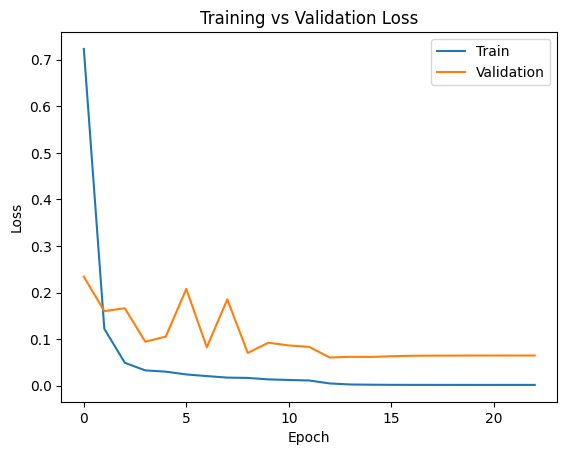

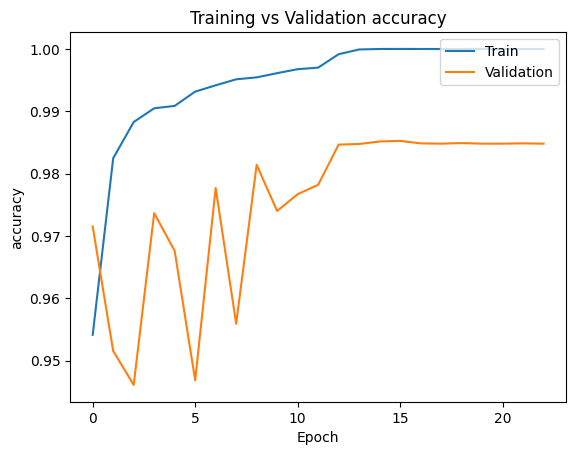

In [23]:
plot_graph_loss(DenseNet_history)
plot_graph_acc(DenseNet_history)
